<a href="https://colab.research.google.com/github/jcandane/RTHF_DensityMatrix/blob/main/RTHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyscf 
!git clone https://github.com/jcandane/RTHF_DensityMatrix

fatal: destination path 'RTHF_DensityMatrix' already exists and is not an empty directory.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import scf, gto
from tqdm import tqdm
import sys
sys.path.insert(1, './RTHF_DensityMatrix/')

plt.style.use("dark_background")

In [6]:
def Expm(A):
    Eigenvalues, Eigenvectors = np.linalg.eig( A )
    return Eigenvectors @  np.diag(  np.exp( Eigenvalues)  )  @ np.linalg.inv(Eigenvectors)

def getAO(DA, DB, Ca, Cb):
    ## transform MO density into an AO density 
    return ( (Ca)@ DA @(Ca.T) ), ( (Cb)@ DB @(Cb.T) )

def getMO(FA, FB, Ca, Cb):
    ## transform AO Fock into an MO Fock 
    return ( (Ca.T)@ FA @(Ca) ), ( (Cb.T)@ FB @(Cb) )

def getFM(Da, Db, H, I):
    J  = np.einsum('ABCD, CD -> AB', I, Da + Db , optimize=True)
    Kα = np.einsum('ABCD, BC -> AD', I, Da , optimize=True)
    Kβ = np.einsum('ABCD, BC -> AD', I, Db , optimize=True)
    Fα = H + J - Kα
    Fβ = H + J - Kβ
    return Fα, Fβ

def RTHF_Unitary(uhf_pyscf, dt = 0.002, dT = 100, field=None):

    if field is None:
      field = E_field()
      field.E0 = 0.
      field.Γ  = 100.

    tsteps = int(dT/dt)
    DA_mo, DB_mo = (uhf_pyscf).mo_occ
    DA_mo  = np.diag(DA_mo).astype(complex)
    DB_mo  = np.diag(DB_mo).astype(complex)

    Ca, Cb = (uhf_pyscf).mo_coeff
    En = (uhf_pyscf).energy_nuc()
    D  = (uhf_pyscf.mol).intor("int1e_r")
    H  = (uhf_pyscf.mol).intor("int1e_kin")
    H += (uhf_pyscf.mol).intor("int1e_nuc")
    I  = (uhf_pyscf.mol).intor("int2e")

    d_tx   = np.zeros((tsteps, 3))
    energy = np.zeros(tsteps)
    trace  = np.zeros(tsteps)
    for step in tqdm(range(tsteps)):
        t = (step) * dt

        DA_ao, DB_ao = getAO(DA_mo, DB_mo, Ca, Cb)
        Fa_ao, Fb_ao = getFM(DA_ao, DB_ao,  H,  I) - np.einsum('xAB, x -> AB', D, field.getEE(t) )
        FA_mo, FB_mo = getMO(Fa_ao, Fb_ao, Ca, Cb)

        #### probe
        d_tx[step]   = np.einsum('xAB, AB -> x', D, ( DA_ao + DB_ao ).real )
        trace[step]  = np.trace(DA_mo.real + DA_mo.real)
        energy[step] = np.einsum("AB, AB -> ", H + Fa_ao, DA_ao/2).real + np.einsum("AB, AB -> ", H + Fb_ao, DB_ao/2).real + En

        UA  = Expm( -1j*(dt)*FA_mo )
        UB  = Expm( -1j*(dt)*FB_mo )

        DA_mo = (UA) @ DA_mo @ ((UA).conj().T)
        DB_mo = (UB) @ DB_mo @ ((UB).conj().T)

    t     = np.arange(0, dT, dt)
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)

    return t, d_tx, energy, trace

class E_field(object):
    ''' A class of Electric Field Pulses '''
    def __init__(self, vector=[0.0, 0.0, 1.0], ω=0., E0=1., Γ=np.inf, t0=0., phase=0.):
        self.vector = np.asarray(vector)
        self.ω = ω
        self.Γ = Γ
        self.phase = phase
        self.t0 = t0
        self.E0 = E0
        
        self.timeline  = None
        self.E_t       = None
        self.freqspace = None
        self.E_ω       = None
        
    def getE(self, t, get_Real=True):
        """ Scalar E-field for a given time/instant t """
        self.E_t = self.E0 * np.exp( - 4*np.log(2) * (t - self.t0)**2/(self.Γ**2) ) * np.exp( -1j * self.ω * (t - self.t0) + 1j * self.phase )
        if get_Real:
            return self.E_t.real
        else:
            return self.E_t
    
    def getEE(self, t):
        """ Vectored E-field for a given time/instant t """
        return ( self.E0 * np.exp( - 4*np.log(2) * (t - self.t0)**2/(self.Γ**2) ) * np.sin( self.ω * (t - self.t0) + 1j * self.phase )) * (self.vector)
        #return ( self.E0 * np.exp( - 4*np.log(2) * (t - self.t0)**2/(self.Γ**2) ) * np.exp( -1j * self.ω * (t - self.t0) + 1j * self.phase )) * (self.vector)
    
    def getEE_whole(self, t):
        """ Vectored E-field for a given time/instant t """
        t = np.asarray([t])
        return np.einsum("t, x -> tx", self.E0 * np.exp( - 4*np.log(2) * (t - self.t0)**2/(self.Γ**2) ) * np.exp( -1j * self.ω * (t - self.t0) + 1j * self.phase ), (self.vector) )
    
    def getEω(self, ω):
        """ Analytic Fourier Transform for Gaussian Wavepacket """
        self.E_ω = self.E0 * self.Γ / (np.sqrt( 8*np.log(2) )) * np.exp( - ( self.Γ**2 * (self.ω - ω)**2 )/( 16*np.log(2) ) ) * np.exp( 1j * (self.phase + ω * self.t0) )
        return self.E_ω
    
    def get_freq(self, timeline, AngularFreq=True):
        """ given timeline (time-array) get corresponding frequency array for FFT """
        T  = timeline[-1]
        dt = timeline[1] - timeline[0]
        f  = np.arange(0.,1/dt + 1/T, 1/T)[:int(len(timeline)/2)]
        
        if AngularFreq:
            self.freqspace = 2*np.pi*f
            return 2*np.pi*f
        else:
            self.freqspace = f
            return f

    def FFT_1D(self, A_t):
        return (np.fft.fft(  A_t  ))[:int(len(A_t)/2)] / np.pi
    
    def get_all(self, t):
        self.getE(t)
        self.get_freq(t)
        self.getEω(self.freqspace)
        return None

In [12]:
field3 = E_field()
field3.E0 = 1e-5
field3.ω  = 0.25
field3.Γ  = 1.
field3.vector = np.array([1.,1.,1.])

### Molecule
mol = gto.M(atom="H 0.0 0.0 0.0; Li 1.6 0.0 0.0")
mol.basis = "sto-3g"
CoM = np.einsum("i, ix-> x", (mol).atom_mass_list(isotope_avg=True), (mol).atom_coords() ) / np.sum( (mol).atom_mass_list(isotope_avg=True) )
mol.set_common_orig_( CoM )

UHF_pyscf = scf.UHF(mol)
UHF_pyscf.conv_tol = 1e-14
UHF_pyscf.kernel()

converged SCF energy = -7.86186476980865  <S^2> = 1.5543122e-15  2S+1 = 1


-7.86186476980865

100%|██████████| 5000/5000 [00:06<00:00, 735.48it/s]


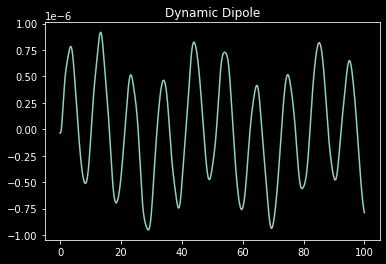

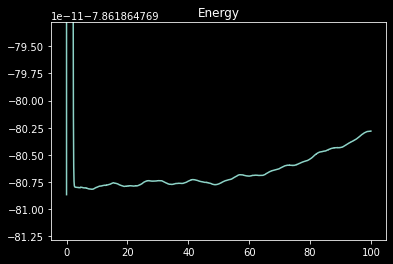

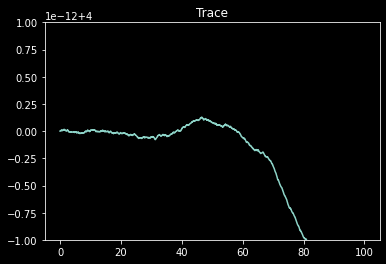

In [8]:
t, d_tx, energy, trace = RTHF_Unitary(UHF_pyscf, dt = 0.02, dT = 100, field=field3)

plt.plot(t, d_tx[:,0])
plt.title("Dynamic Dipole")
plt.show()

ε = 1e-11
plt.plot(t, energy)
plt.ylim([ energy[-1] - ε, energy[-1] + ε])
plt.title("Energy")
plt.show()

ε = 1e-12
plt.plot(t, trace)
plt.ylim([ trace[0] - ε, trace[0] + ε])
plt.title("Trace")
plt.show()